# Hearing the phase of a sound

In this notebook we will investigate the effect of phase on the perceptual quality of a sound. It is often said that the human ear is lergely insensitive to phase and that's why most of the equalization in commercial-grade audio equipment takes place in the magnitude domain only.

But is it really so? Let's find out.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
from scipy.io import wavfile

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

We will be synthesizing audio clips so let's set the sampling rate for the rest of the not:

In [3]:
Fs = 16000 # sampling freqency
TWOPI = 2 * np.pi

We will be synthesizing and playing audio clips so let's define a convenience function to "beautify" the resulting sound: basically, we want a gentle fade-in and fade-out to avoid abrupt "clicks" when the waveform begins and ends. 

Also, there is a "bug" in the current version of IPython whereby audio data is forcibly normalized prior to playing (see [here](https://github.com/ipython/ipython/issues/8608) for details; this may have been solved in the meantime). On the other hand, we want to avoid normalization in order to keep control over the volume of the sound. A way to do so is to make sure that all audio clips have at least one sample at a pre-defined maximum value, and this value is the same for all clips. To do so we add a slow "tail" to the data which will not result in an audible sound but will set a common maximum value in all clips.

In [4]:
def prepare(x, max_value = 3):
    N = len(x)
    # fade-in and fade-out times max 0.2 seconds
    tf = min(int(0.2 * Fs), int(0.1 * N))
    for n in range(0, int(tf)):
        s = float(n) / float(tf)
        x[n] *= s
        x[N-n-1] *= s
    # let's append an anti-normalization tail; drawback is one second of silence in the end
    x = np.concatenate((x, np.linspace(0, max_value, int(Fs/2)), np.linspace(max_value, 0, int(Fs/2))))
    return x

## 1) Sustained sounds

The first experiment will use sustained sounds, i.e. waveform whose global envelope does not change in time. A periodic sustained waveform is simply the sum of harmonically-related sinusoidal components, i.e. a set of sines or cosines with different amplitudes and phases at frequencies multiple of a fundamental. The fundamental frequency is also known as the <i>pitch</i> of the sound.

A class of instruments that produce good sustained sounds is the woodwinds (clarinet, saxophone, etc). The mechanics of sound generation in woodwinds are beyond the scope of this notebook and plenty of references can be found on the internet. For our purposes we will choose to simulate a clarinet according to the analysis described [here](http://www.phy.mtu.edu/~suits/clarinet.html).

![title](clarinet.png)

A clarinet-like sustained sound will contain frequencies at odd multiples of the fundamental. We will just keep the fundamental and five harmonics and we be able to specify the initial phase offset for each component:

In [5]:
def clarinet(f, phase = []):
    # length in seconds of audio clips
    T = 3
    
    # we will keep 5 harmonics and the fundamental
    # amplitude of components: 
    ha = [0.75, 0.5, 0.14, 0.5, 0.12, 0.17]
    
    # phase
    phase = np.concatenate((phase, np.zeros(len(ha)-len(phase))))

    x = np.zeros((T * Fs))
    # clarinet has only odd harmonics
    n = np.arange(len(x))
    for k, h in enumerate(ha):
        x += h * np.sin(phase[k] + TWOPI * (2*k + 1) * (float(f)/Fs) * n)
    return x

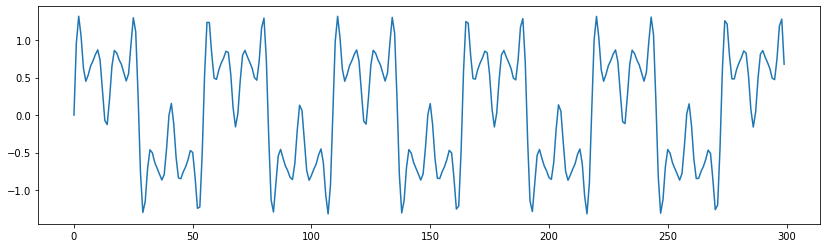

In [6]:
# fundamental frequency: D4
D4 = 293.665
x = clarinet(D4)

# let's look at the waveform, nice odd-harmonics shape:    
plt.plot(x[0:300])
plt.show()

# and of course we can play it (using our preparing function):
IPython.display.Audio(prepare(x), rate=Fs)

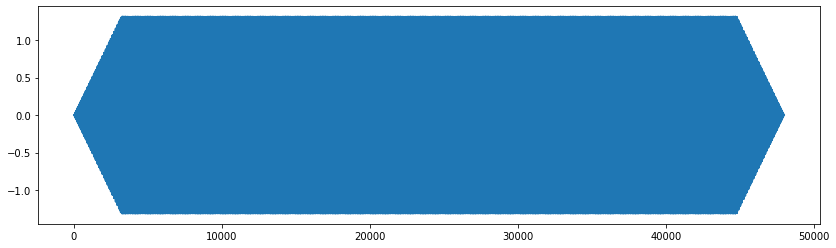

In [7]:
plt.plot(x)

Ok, so it's not the best clarinet sound in the universe but it's not bad for just a few lines of code. Now let's see how changing the phase affects the sound. Let's just use random phase offsets for the components: we can see that the waveform doesn't look too nice anymore:

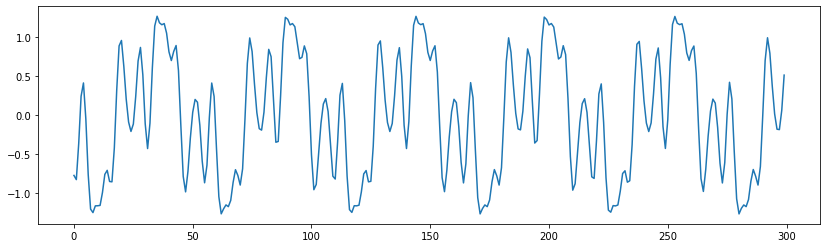

In [8]:
xrp = clarinet(D4, [3.84, 0.90, 3.98, 4.50, 4.80, 2.96])

plt.plot(xrp[0:300])
plt.show()

In [9]:
# but if we play it, it sounds the same!    
IPython.display.Audio(prepare(xrp), rate=Fs)

OK, so it seems that phase is not important after all. To check once again, run the following notebook cell as many times as you want and see if you can tell the difference between the original zero-phase and a random-phase sustained note (the phases will be different every time you run the cell):

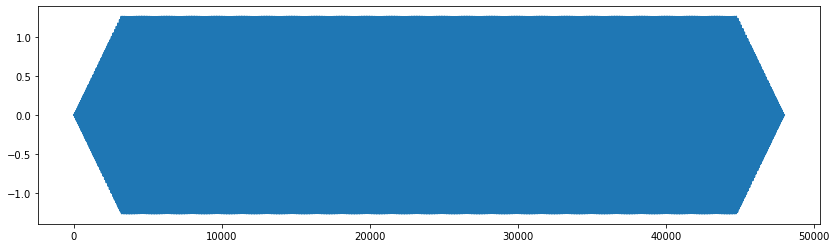

In [10]:
plt.plot(xrp)

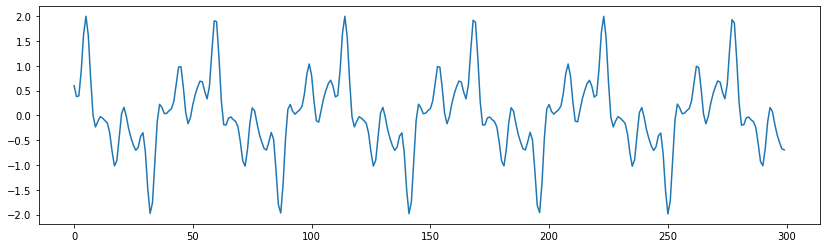

In [11]:
xrp = clarinet(D4, np.random.rand(6) * TWOPI)
plt.plot(xrp[0:300])
plt.show()  
IPython.display.display(IPython.display.Audio(prepare(x), rate=Fs))
IPython.display.display(IPython.display.Audio(prepare(xrp), rate=Fs))

## 1) Dynamic sounds

In the second experiment we will use real-world dynamic sounds, i.e. sounds that display time-varying characteristics. Typically, a physical musical instrument will produce sounds whose envelope displays four subsequent portions:

* the **attack** time is the time taken for the sound to go from silence to max amplitude
* the **decay** time is the time taken for the sound to decrease to sustain level
* the **sustain** time is the time during the sound is kept at the same amplitude
* the **release** time is the time taken for sound to go to zero after the stimulation is stopped.

![title](piano.jpg)

Consider for instance a piano note: the attack time is very quick (the hammer hits the string); the decay is quite rapid as the string settles into harmonic equilibrium but there is no sustain since once the hammer hits, the stimulation ends. So a piano note has a distinct volume envelope that rises very fast and then releases slowly:

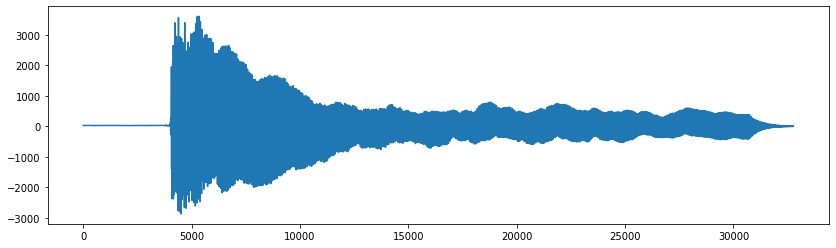

In [12]:
from scipy.io import wavfile
Fs, x = wavfile.read("piano.wav")
plt.plot(x)
plt.show() 
IPython.display.Audio(x, rate=Fs)

By now we know that the "shape" of a waveform is largely encoded in the phase. It is no surprise, therefore, that if we mess up with the phase of the piano sample above, we will get something that looks very different.

To see this, let's take the DFT of the audio data, set the phase to zero and take the IDFT:

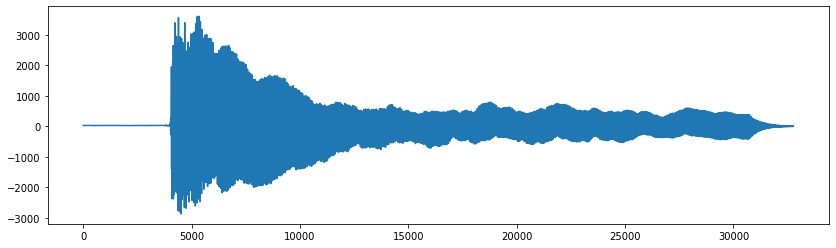

In [13]:
# first some prep work; let's make sure that
#  the length of the signal is even 
#  (it will be useful later)
if len(x) % 2 != 0:
    x = x[:-1]
plt.plot(x)

# let's also store the maximum value for our 
#  "prepare" function   
mv = int(max(abs(x)) * 1.2)

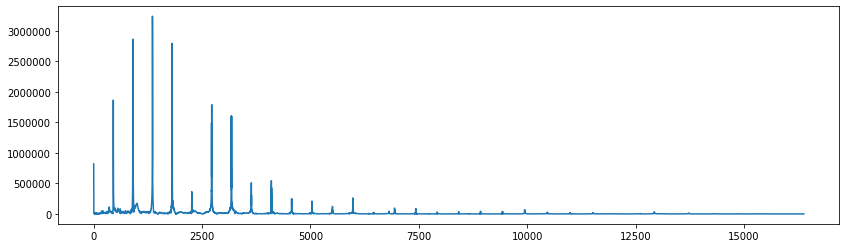

In [14]:
# Let's take the Fourier transform
X = np.fft.fft(x)

# we can plot the DFT and verify we have a nice 
#  harmonic spectrum
plt.plot(np.abs(X[0:int(len(X)/2)]))
plt.show() 

In [15]:
# now we set the phase to zero; we just need to
#  take the magnitude of the DFT
xzp = np.fft.ifft(np.abs(X))

# in theory, xzp should be real; however, because
#  of numerical imprecision, we're left with some imaginary crumbs:
print (max(np.imag(xzp)) / max(np.abs(xzp)))

4.66957377590237e-17


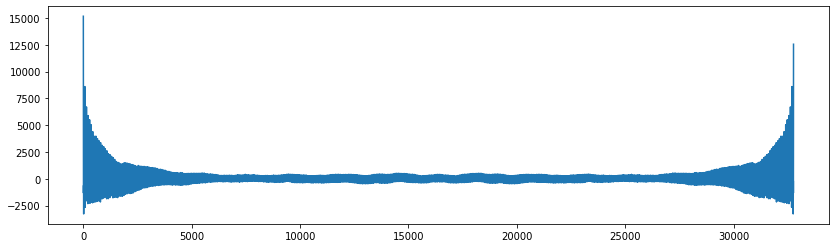

In [16]:
# the imaginary part is negligible, as expected, 
#  so let's just get rid of it
xzp = np.real(xzp)

# and now we can plot:
plt.plot(xzp)
plt.show() 

Gee, what happened?!? Well, by removing the phase, we have destroyed the timing information that, for instance, made the sharp attack possible (mathematically, note that by creating a zero-phase spectrum we did obtain a symmetric signal in the time domain!).

If we play the waveform, we can hear that the pitch and some of the timbral quality have been preserved (after all, the magnitude spectrum is the same), but the typical piano-like envelope has been lost.

In [17]:
IPython.display.Audio(prepare(xzp, mv), rate=Fs)


We can amuse ourselves with even more brutal phase mangling: let's for instance set a random phase for each DFT component. The only tricky thing here is that we need to preserve the Hermitian symmetry of the DFT in order to have a real-valued time-domain signal:

In [18]:
# we know the signal is even-length so we need to build
#  a phase vector of the form [0 p1 p2 ... pM -pM ... -p2 -p1]
#  where M = len(x)/2
ph = np.random.rand(int(len(x) / 2) ) * TWOPI * 1j
# tricky but cute Python slicing syntax...
ph = np.concatenate(([0], ph, -ph[-2::-1]))

# now let's add the phase offset and take the IDFT
xrp = np.fft.ifft(X * np.exp(ph))

# always verify that the imaginary part is only roundoff error
print (max(np.imag(xrp))/max(np.abs(xrp)))

1.742642645131969e-06


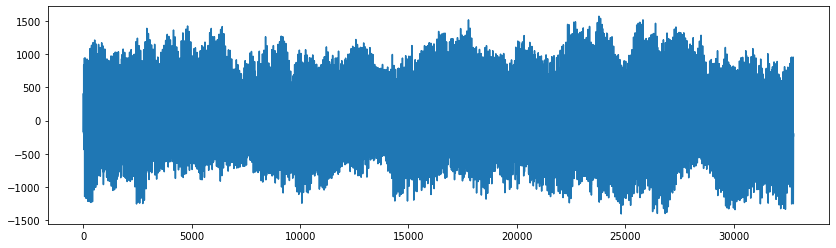

In [19]:
xrp = np.real(xrp)
plt.plot(xrp)
plt.show()

IPython.display.Audio(prepare(xrp, mv), rate=Fs)

Pretty bad, eh? So, in conclusion, phase is very important to the temporal aspects of the sound, but not so important for sustained sounds. In fact, the brain processes the temporal and spectral cues of sound very differently: when we concentrate on attacks and sound envelope, the brain uses time-domain processing, whereas for pitch and timbre, it uses primarily the magnitude of the spectrum!